In [1]:
import sys
sys.path.insert(0, '../')
from detectron2_extensions.config import get_cfg
import vq2d.data
import torch
sys.path.insert(0, '../../Detic/')
sys.path.insert(0, '../../Detic/third_party/CenterNet2')
sys.path.insert(0, '../../Detic/third_party/Deformable-DETR')
from detic.config import add_detic_config
from centernet.config import add_centernet_config
from detectron2_extensions.data.dataset_mapper import DatasetMapper
from detectron2.data import get_detection_dataset_dicts
from detectron2.modeling import build_model
from detectron2.evaluation import inference_context
from detectron2.checkpoint import DetectionCheckpointer


In [2]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("../../Detic/configs/Detic_LCOCOI21k_CLIP_R5021k_640b32_4x_ft4x_max-size.yaml")
args_str = "MODEL.WEIGHTS ../../Detic/models/Detic_LCOCOI21k_CLIP_R5021k_640b32_4x_ft4x_max-size/Detic_LCOCOI21k_CLIP_R5021k_640b32_4x_ft4x_max-size.pth OUTPUT_DIR /scratch/shared/beegfs/prannay/ego4d_data/detic_ckpt/perframe_run_detic/ DATASETS.TEST ('vq2d_val_pos_frame_only_vc',) MODEL.RPN.PRE_NMS_TOPK_TEST 6000 MODEL.ROI_HEADS.SCORE_THRESH_TEST 0.0 TEST.DETECTIONS_PER_IMAGE 128 MODEL.ROI_SIAMESE_HEAD.TOKEN_NUMBER_PER_IMAGE 1000 DATASETS.NUM_SHARDS 5000 DATASETS.SHARD_ID 0 MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH 'rand' MODEL.ROI_BOX_HEAD.CAT_FREQ_PATH ../Detic/datasets/metadata/lvis_v1_train_cat_info.json MODEL.META_ARCHITECTURE CustomSiameseRCNN MODEL.MASK_ON False MODEL.ROI_BOX_HEAD.NORM_TEMP 1.0"
cfg.merge_from_list(args_str.split(" "))

In [3]:
model = build_model(cfg)
_ = DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


In [4]:
dataset_dicts = get_detection_dataset_dicts(cfg.DATASETS.TEST, filter_empty=False, proposal_files=None)

In [6]:
mapper = DatasetMapper(cfg, False)

In [7]:
inputs_easy = mapper(dataset_dicts[59])
inputs_hard = mapper(dataset_dicts[0])

In [11]:
with torch.no_grad(), inference_context(model):
    outputs_easy = model([inputs_easy], do_postprocess=False)
    outputs_hard = model([inputs_hard], do_postprocess=False)


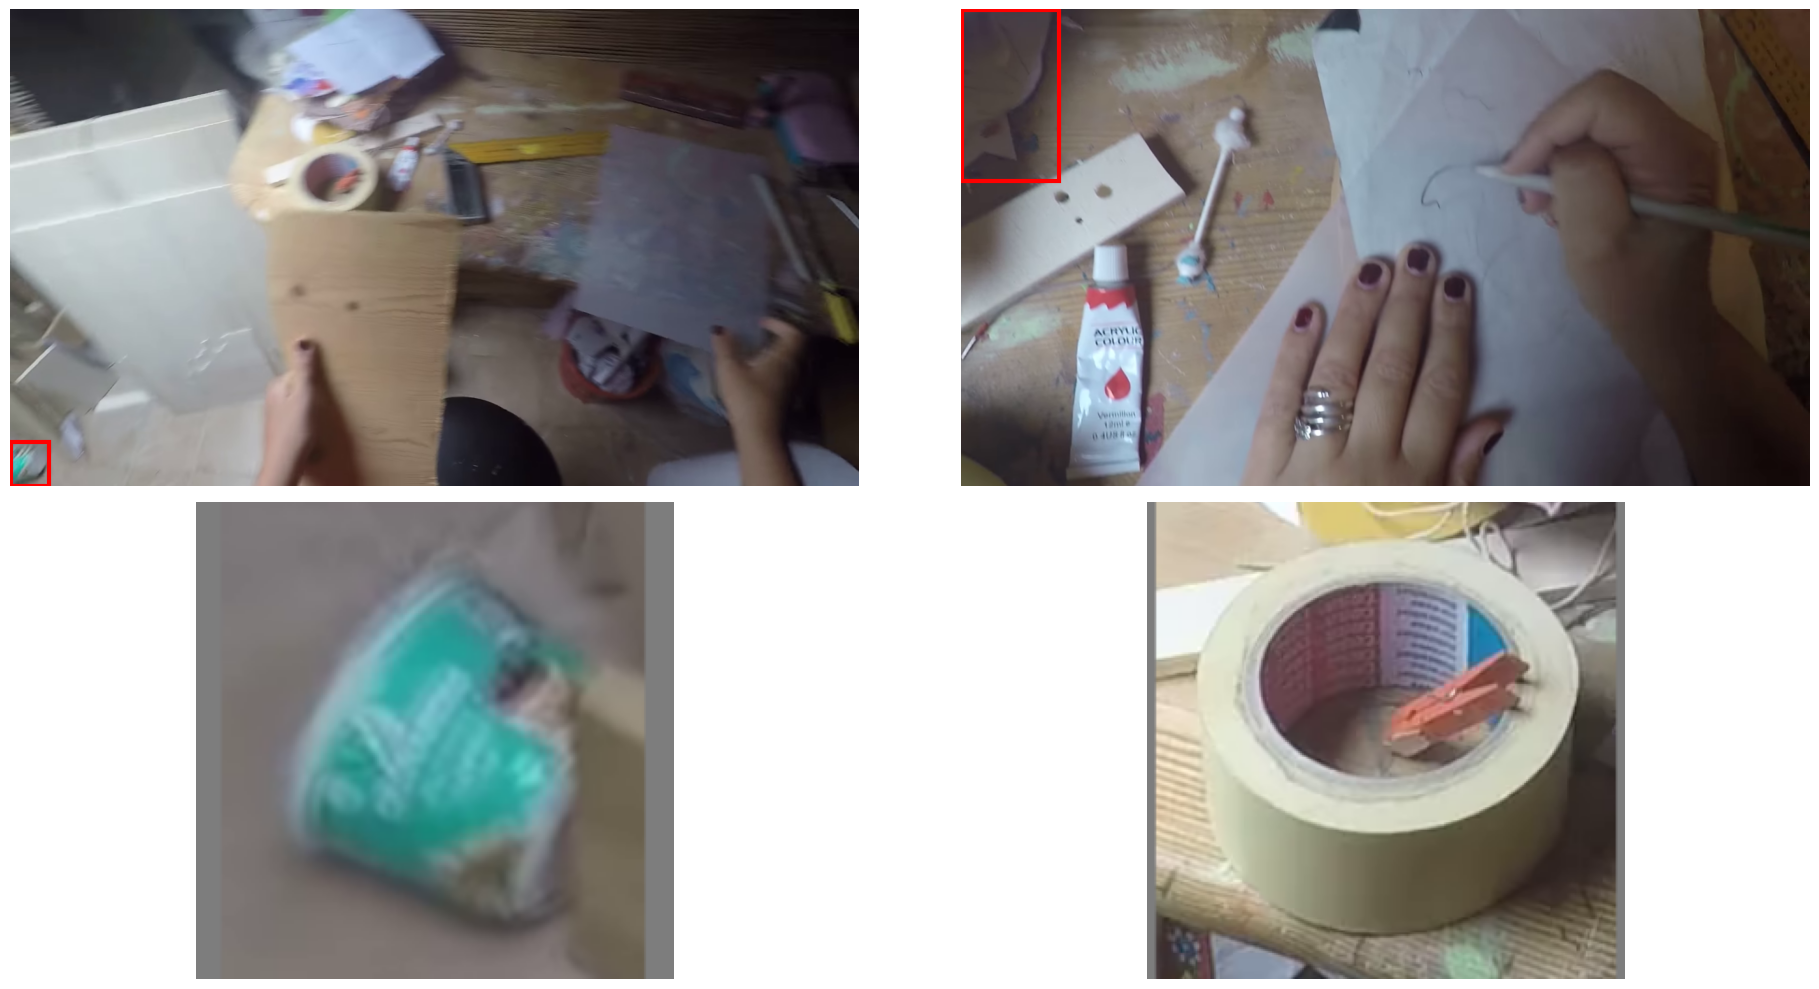

In [16]:
# plot the image, reference and the top 10 predictions
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(inputs_easy["image"].permute(1, 2, 0).cpu().numpy())
ax[0, 1].imshow(inputs_hard["image"].permute(1, 2, 0).cpu().numpy())
ax[1, 0].imshow(inputs_easy["reference"].byte().permute(1, 2, 0).cpu().numpy())
ax[1, 1].imshow(inputs_hard["reference"].byte().permute(1, 2, 0).cpu().numpy())
easy_preds = outputs_easy[0].to("cpu")
hard_preds = outputs_hard[0].to("cpu")
for i in range(1):
    pred = easy_preds[i]
    bbox = pred.pred_boxes.tensor[0]
    ax[0, 0].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color="red", linewidth=3))
    pred = hard_preds[i]
    bbox = pred.pred_boxes.tensor[0]
    ax[0, 1].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color="red", linewidth=3))
for a in ax.ravel(): a.set_axis_off()
plt.tight_layout()
plt.show()